# Making predictions and decisions with medical trial data

We have data for 6 studies that have been done on the effect of *specific allergen immunotherapy* (SIT) on eczema and the following success rates have been observed. In each of the trials, the investigator rated whether each patient's condition improved or not.

This data set is from the [Cochrane Database of Systematic Reviews](http://www.cochranelibrary.com/) article cited below, available for free [here](http://onlinelibrary.wiley.com/doi/10.1002/14651858.CD008774.pub2/full). The Cochrane Database is a great resource for high quality data on all sorts of medical trials.

> Tam H., Calderon M.A., Manikam L., Nankervis H., García Núñez I., Williams H.C., Durham S., Boyle R.J. (2016). Specific allergen immunotherapy for the treatment of atopic eczema. *Cochrane Database of Systematic Reviews, Issue 2*. Art. No.: CD008774. DOI: 10.1002/14651858.CD008774.pub2.

| Study          | Improved | Not improved |
|:-------------- | --------:| ------------:|
| Di Rienzo 2014 | 20       | 3            |
| Galli 1994     | 10       | 6            |
| Kaufman 1974   | 13       | 3            |
| Qin 2014       | 35       | 10           |
| Sanchez 2012   | 22       | 9            |
| Silny 2006     | 7        | 3            |
| **Totals**     | **107**  | **34**       |

## Task 1: Modeling
**Build a statistical model for this data set.** As your data, use the total number of patients improved (107) and not improved (34).

**Steps in the modeling process:**
1. Choose and motivate for an appropriate likelihood function for this type of data.
    1. Make sure the support of your likelihood function matches the type of data we are working with.
    2. Describe the unobserved parameter(s) of your model, and describe how it/they can be interpreted.
2. Use a conjugate prior distribution for your likelihood function.
    1. Select appropriate values for the prior hyperparameters and motivate your choice.
    2. Visualize your prior distribution.
3. Compute and visualize the posterior distribution over the unobserved parameter(s) of your model. Also describe what the posterior tells you about the parameter(s).

Feel free to discuss this task with other students in the course, or attempt it on your own if you prefer. Discussing your modeling ideas with other students is a useful way to get feedback on your assumptions.

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats as sts

In [10]:
'''
Function definitions for the normal-inverse-gamma distribution. The parameters
of the distribution, namely mu (μ), either lambda (λ) or nu (ν), alpha (α),
beta (β), are used as defined here:

  https://en.wikipedia.org/wiki/Normal-inverse-gamma_distribution

Note that we use the symbol nu (ν) rather than lambda (λ) for the third
parameter. This is to match the notation used in the conjugate priors table on
Wikipedia:

  https://en.wikipedia.org/wiki/Conjugate_prior#Table_of_conjugate_distributions
'''

def norminvgamma_pdf(x, sigma2, mu, nu, alpha, beta):
    '''
    The probability density function of the normal-inverse-gamma distribution at
    x (mean) and sigma2 (variance).
    '''
    return (
        sts.norm.pdf(x, loc=mu, scale=np.sqrt(sigma2 / nu)) *
        sts.invgamma.pdf(sigma2, a=alpha, scale=beta))

def norminvgamma_rvs(mu, nu, alpha, beta, size=1):
    '''
    Generate n samples from the normal-inverse-gamma distribution. This function
    returns a (size x 2) matrix where each row contains a sample, (x, sigma2).
    '''
    # Sample sigma^2 from the inverse-gamma distribution
    sigma2 = sts.invgamma.rvs(a=alpha, scale=beta, size=size)
    # Sample x from the normal distribution
    x = sts.norm.rvs(loc=mu, scale=np.sqrt(sigma2 / nu), size=size)
    return np.vstack((x, sigma2)).transpose()

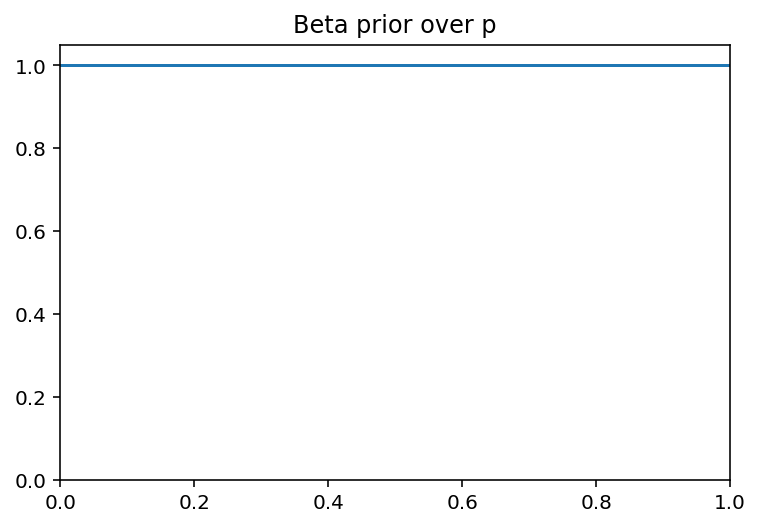

In [2]:
# This data set comprises the number of successes and failures in a medical trial.
data = {'improved': 107, 'not improved': 34}

# The binomial distribution is an appropriate likelihood function for this type
# of data. The support of the binomial distribution is the non-negative integers,
# representing the number of successes out of n trials.

# The unobserved parameter p of the binomial likelihood is the probability of
# single patient getting better when getting the treatment.

# We use the conjugate beta prior distribution over the parameter p. The prior
# hyperparameters are chosen to be α=1 and β=1 since that gives us a uniform
# (very uncertain) distribution over p, which is appropriate since we are given
# no information about what p might be.
alpha_prior = 1
beta_prior = 1
prior = stats.beta(a=alpha_prior, b=beta_prior)
#norminvgamma_rvs(mu, nu, alpha, beta, size=1)
# Plot the prior
plot_x = np.linspace(0, 1, 200)
plot_y = prior.pdf(plot_x)
plt.plot(plot_x, plot_y)
plt.title('Beta prior over p')
plt.xlim(0, 1)
plt.ylim(0, 1.05)
plt.show()

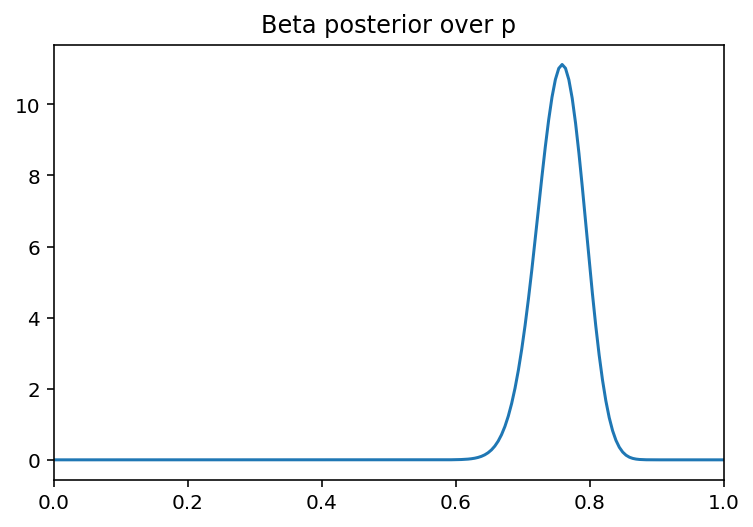

Expected probability of treatment success: 0.755
95% confidence interval over probability of treatment success: [0.682, 0.822]


In [3]:
# Compute posterior hyperparameters
alpha_post = alpha_prior + data['improved']
beta_post = beta_prior + data['not improved']
posterior = stats.beta(a=alpha_post, b=beta_post)

# Plot the posterior
plot_x = np.linspace(0, 1, 200)
plot_y = posterior.pdf(plot_x)
plt.plot(plot_x, plot_y)
plt.title('Beta posterior over p')
plt.xlim(0, 1)
plt.show()

# Describe posterior
print(
    'Expected probability of treatment success: %.3f' %
    (posterior.mean()))
print(
    '95%% confidence interval over probability of treatment success: [%.3f, %.3f]' %
    posterior.interval(0.95))

## Task 2: Questions, predictions, and decisions
1. Posterior predictive distribution: Use your model to predict how many patients would improve if we treated 100 new eczema patients using SIT. Express your answer as a probability distribution over the number of patients improved.
2. Use your posterior to answer these questions:
    1. What is the probability that at least two thirds of eczema patients get better with SIT?
    2. What is the probability that at least 75% of eczema patients get better with SIT?
3. Use your model to decide whether the treatment works or not. Motivate your answer.

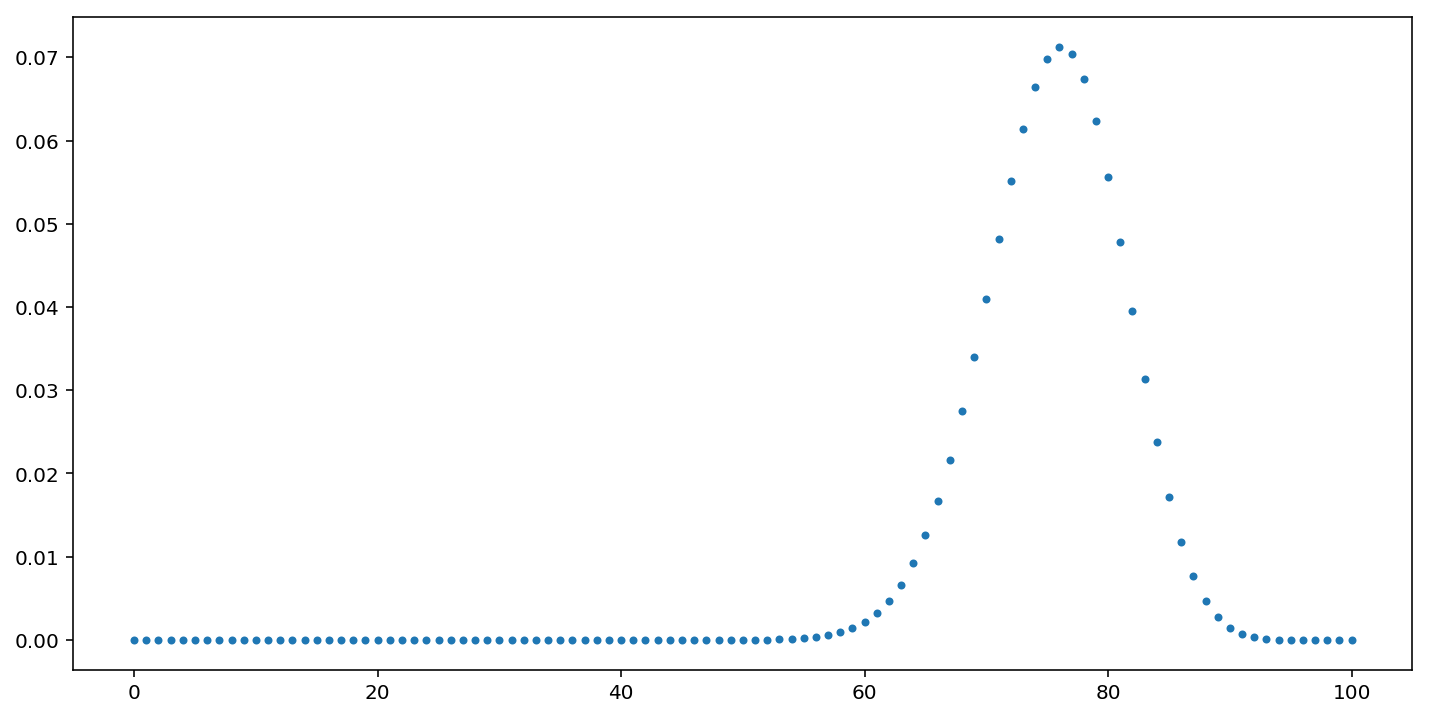

In [4]:
# Beta-binomial pmf with 100 patients and alpha_post and beta_post parameters
def beta_binomial_pmf(k, n, alpha, beta):
    from scipy.special import betaln, comb
    log_pmf = np.log(comb(n, k)) + betaln(k + alpha, n - k + beta) - betaln(alpha, beta)
    return np.exp(log_pmf)

x = np.arange(0, 101)
y = beta_binomial_pmf(x, 100, alpha_post, beta_post)
plt.figure(figsize=(12, 6))
plt.plot(x, y, '.')
plt.show()

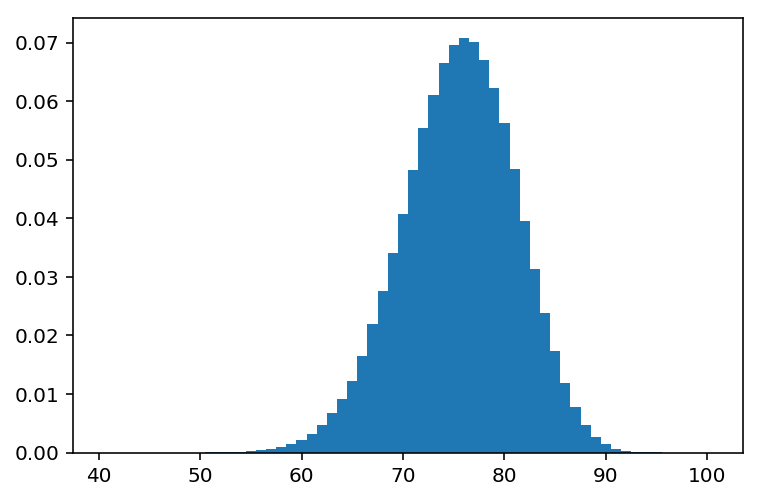

In [5]:
# Using sampling from posterior + likelihood for posterior predictive
samples = 1000000
counts = stats.binom.rvs(100, posterior.rvs(size=samples), size=samples)
plt.hist(counts, bins=np.arange(40, 101) + 0.5, density=True)
plt.show()

In [6]:
print('Probability that at least 2/3 of patients get better: %.3f' %
      (1 - posterior.cdf(2/3)))
print('Probability that at least 75%% of patients get better: %.3f' %
      (1 - posterior.cdf(0.75)))

Probability that at least 2/3 of patients get better: 0.990
Probability that at least 75% of patients get better: 0.571


In [1]:
def f(x):
    # Normal-inverse-gamma prior hyperparameters
    mu_0 = x[0]        # The prior mean is centered around 0.
    nu_0 = x[1]   # The smaller ν₀ is, the more uncertain we are about the prior mean.
    alpha_0 = x[2]  # α₀ and β₀ control the marginal prior over the variance.
    beta_0 = x[3]
    
    
    meanmu= mu_0
    var= beta_0/((alpha_0-1)*nu_0)
    meanvar= beta_0/(alpha_0-1)
    varvar= beta_0**2/((alpha_0-1)**2*beta_0/(alpha_0-2))
    
    return (meanmu-2.3)**2 + (var-0.5)**2 + (meanvar-2.75)**2 + (varvar-1)**2
    
    

In [3]:
from scipy.optimize import minimize

x_initial = [2,3,4,5]
result = minimize(f,x_initial)
x_final = result.x
print(x_final)

[2.30000246 5.50020494 2.57143803 4.32146403]


In [11]:
prior = norminvgamma_rvs(mu=x_final[0], nu=x_final[1], alpha=x_final[2], beta=x_final[3], size=1)
